In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from iid_modeling_loocv import iid_modeling_loocv

import os
import pandas as pd
import time
# import tensorflow as tf
# print(tf.__version__)
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score,roc_curve
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.utils import resample

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns 
sns.set(rc = {'figure.figsize':(8,5)})
sns.set_style("white", {'font.family':'serif', 'font.serif':'Times Roman'})
sns.set_context("talk")
sns.set_palette("crest")

## Loading parquet files in dictionary

Need to update `specific folder` variable as necessary

In [4]:
loaded_parquet_df = {}
directory_location = '../data/dwt_df_parquet/'
specific_folder = 'seg_2.5_hop_0.5_ovlap_0.5/'
for dirName, _, fileList in os.walk(f'{directory_location}{specific_folder}'):
    for fname in fileList:
        if fname.endswith('parquet'):
            loaded_parquet_df[fname] = pd.read_parquet(f'{directory_location}{specific_folder}{fname}')

In [5]:
total_obs = 0
for key, val in loaded_parquet_df.items():
    print(f'{key}: {val.shape}')
    total_obs += val.shape[0]
    print(f'{key} has {val.isnull().sum().sum()} missing values')

print(f'Total number of observations: {total_obs}')

7r367wUYs1EvyBbeyOcq39.parquet: (917, 27564)
7r367wUYs1EvyBbeyOcq39.parquet has 0 missing values
1jfWVd1sTapjjkQwDM4yQX.parquet: (710, 27564)
1jfWVd1sTapjjkQwDM4yQX.parquet has 0 missing values
1XgTQnRlfJ0zpDdg2DccbR.parquet: (5626, 27564)
1XgTQnRlfJ0zpDdg2DccbR.parquet has 0 missing values
79aiOALBohH9vEIUHPAoRj.parquet: (5599, 27564)
79aiOALBohH9vEIUHPAoRj.parquet has 0 missing values
7LxbgPH3grqf6lCpLKEwo7.parquet: (824, 27564)
7LxbgPH3grqf6lCpLKEwo7.parquet has 0 missing values
0pIwpmg5oPcMWJXVSyrx4E.parquet: (985, 27564)
0pIwpmg5oPcMWJXVSyrx4E.parquet has 0 missing values
7vxD3WNDRkigLnIDHyy0cu.parquet: (926, 27564)
7vxD3WNDRkigLnIDHyy0cu.parquet has 0 missing values
6hoNS9LR1Lxb4EzMX72kXR.parquet: (5897, 27564)
6hoNS9LR1Lxb4EzMX72kXR.parquet has 0 missing values
2DCEgkjSeRQyMt8KovG8vF.parquet: (834, 27564)
2DCEgkjSeRQyMt8KovG8vF.parquet has 0 missing values
0TkGYYIPwRqx8xzP0XGvRG.parquet: (3010, 27564)
0TkGYYIPwRqx8xzP0XGvRG.parquet has 0 missing values
2hgBlERSFYDWndqjWNOV6v.par

In [6]:
for i in loaded_parquet_df:
    print(i, '\n', loaded_parquet_df[i].y.value_counts())

7r367wUYs1EvyBbeyOcq39.parquet 
 0    869
1     48
Name: y, dtype: int64
1jfWVd1sTapjjkQwDM4yQX.parquet 
 0    710
Name: y, dtype: int64
1XgTQnRlfJ0zpDdg2DccbR.parquet 
 0    5377
1     249
Name: y, dtype: int64
79aiOALBohH9vEIUHPAoRj.parquet 
 0    5530
1      69
Name: y, dtype: int64
7LxbgPH3grqf6lCpLKEwo7.parquet 
 0    814
1     10
Name: y, dtype: int64
0pIwpmg5oPcMWJXVSyrx4E.parquet 
 0    962
1     23
Name: y, dtype: int64
7vxD3WNDRkigLnIDHyy0cu.parquet 
 0    904
1     22
Name: y, dtype: int64
6hoNS9LR1Lxb4EzMX72kXR.parquet 
 0    5705
1     192
Name: y, dtype: int64
2DCEgkjSeRQyMt8KovG8vF.parquet 
 0    821
1     13
Name: y, dtype: int64
0TkGYYIPwRqx8xzP0XGvRG.parquet 
 0    2916
1      94
Name: y, dtype: int64
2hgBlERSFYDWndqjWNOV6v.parquet 
 0    4679
1      82
Name: y, dtype: int64


In [7]:
hot_take = ['0pIwpmg5oPcMWJXVSyrx4E.parquet',
            '7vxD3WNDRkigLnIDHyy0cu.parquet',
           '7r367wUYs1EvyBbeyOcq39.parquet',
           '7LxbgPH3grqf6lCpLKEwo7.parquet',
           '0TkGYYIPwRqx8xzP0XGvRG.parquet',
           '2DCEgkjSeRQyMt8KovG8vF.parquet']

hot_take_parquet_df = {i:loaded_parquet_df[i] for i in loaded_parquet_df if i in hot_take}

for i in hot_take_parquet_df:
    print(i, '\n', hot_take_parquet_df[i].y.value_counts())

7r367wUYs1EvyBbeyOcq39.parquet 
 0    869
1     48
Name: y, dtype: int64
7LxbgPH3grqf6lCpLKEwo7.parquet 
 0    814
1     10
Name: y, dtype: int64
0pIwpmg5oPcMWJXVSyrx4E.parquet 
 0    962
1     23
Name: y, dtype: int64
7vxD3WNDRkigLnIDHyy0cu.parquet 
 0    904
1     22
Name: y, dtype: int64
2DCEgkjSeRQyMt8KovG8vF.parquet 
 0    821
1     13
Name: y, dtype: int64
0TkGYYIPwRqx8xzP0XGvRG.parquet 
 0    2916
1      94
Name: y, dtype: int64


## Creating train-test sets

In [56]:
logreg = LogisticRegression(penalty = 'l2', class_weight ='balanced', max_iter = 1e10)

logreg_model_metrics = iid_modeling_loocv(loaded_parquet_df, logreg)

7r367wUYs1EvyBbeyOcq39.parquet will be the test podcast
Training set size: (29168, 27564)
Test set size: (917, 27564)
7r367wUYs1EvyBbeyOcq39.parquet scores: accuracy = 0.9160, precision = 0.0323, recall = 0.0208, f1_score = 0.0253
TN=839   FP=30   FN=47   TP=1
7r367wUYs1EvyBbeyOcq39.parquet completed in 27.81 seconds

1jfWVd1sTapjjkQwDM4yQX.parquet will be the test podcast
Training set size: (29375, 27564)
Test set size: (710, 27564)


/home/ec2-user/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ec2-user/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ec2-user/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start,

1XgTQnRlfJ0zpDdg2DccbR.parquet will be the test podcast
Training set size: (24459, 27564)
Test set size: (5626, 27564)
1XgTQnRlfJ0zpDdg2DccbR.parquet scores: accuracy = 0.9365, precision = 0.0424, recall = 0.0201, f1_score = 0.0272
TN=5264   FP=113   FN=244   TP=5
1XgTQnRlfJ0zpDdg2DccbR.parquet completed in 26.59 seconds

79aiOALBohH9vEIUHPAoRj.parquet will be the test podcast
Training set size: (24486, 27564)
Test set size: (5599, 27564)
79aiOALBohH9vEIUHPAoRj.parquet scores: accuracy = 0.9289, precision = 0.0000, recall = 0.0000, f1_score = 0.0000
TN=5201   FP=329   FN=69   TP=0
79aiOALBohH9vEIUHPAoRj.parquet completed in 26.45 seconds

7LxbgPH3grqf6lCpLKEwo7.parquet will be the test podcast
Training set size: (29261, 27564)
Test set size: (824, 27564)
7LxbgPH3grqf6lCpLKEwo7.parquet scores: accuracy = 0.9527, precision = 0.0323, recall = 0.1000, f1_score = 0.0488
TN=784   FP=30   FN=9   TP=1
7LxbgPH3grqf6lCpLKEwo7.parquet completed in 29.38 seconds

0pIwpmg5oPcMWJXVSyrx4E.parquet wil

In [11]:
logreg_model_metrics

{'7r367wUYs1EvyBbeyOcq39.parquet': {'model': LogisticRegression(class_weight='balanced', max_iter=10000000000.0),
  'y_pred': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

## Create a single model used for testing Random Forest and Adaboost

In [24]:
train_dfs_for_hottake, train_dfs_for_aus = [], []

test_podcast_hottake = ['0pIwpmg5oPcMWJXVSyrx4E.parquet','7r367wUYs1EvyBbeyOcq39.parquet']
test_podcast_aus = '1XgTQnRlfJ0zpDdg2DccbR.parquet'


for key, val in loaded_parquet_df.items():
    if key != test_podcast_hottake[0] and key != test_podcast_hottake[1]:
        train_dfs_for_hottake.append(val)
        
for key, val in loaded_parquet_df.items():
    if key != test_podcast_aus:
        train_dfs_for_aus.append(val)
    
# get the training set
# https://pandas.pydata.org/pandas-docs/stable/user_guide/merging.html
train_set_for_hottake = pd.concat(train_dfs_for_hottake).dropna()
print(train_set_for_hottake.shape)

train_set_for_aus = pd.concat(train_dfs_for_aus).dropna()
print(train_set_for_aus.shape)


# get the test set
test_set_hottake = pd.concat([loaded_parquet_df[test_podcast_hottake[0]],loaded_parquet_df[test_podcast_hottake[1]]]).dropna()
print(test_set_hottake.shape)

test_set_aus = loaded_parquet_df[test_podcast_aus].dropna()
print(test_set_aus.shape)

(28183, 27564)
(24459, 27564)
(1902, 27564)
(5626, 27564)


In [25]:
X_train_hottake, y_train_hottake = train_set_for_hottake.drop('y', axis=1), train_set_for_hottake['y']
print(X_train_hottake.shape)
print(y_train_hottake.shape)

(28183, 27563)
(28183,)


In [26]:
X_train_aus, y_train_aus = train_set_for_aus.drop('y', axis=1), train_set_for_aus['y']
print(X_train_aus.shape)
print(y_train_aus.shape)

(24459, 27563)
(24459,)


In [27]:
X_test_hottake, y_test_hottake = test_set_hottake.drop('y', axis=1), test_set_hottake['y']
print(X_test_hottake.shape)
print(y_test_hottake.shape)

(1902, 27563)
(1902,)


In [28]:
X_test_aus, y_test_aus = test_set_aus.drop('y', axis=1), test_set_aus['y']
print(X_test_aus.shape)
print(y_test_aus.shape)

(5626, 27563)
(5626,)


# Logistic Regression

In [29]:
logreg_hottake = LogisticRegression(penalty = 'l2', class_weight ='balanced', max_iter = 1e10)
logreg_hottake.fit(X_train_hottake, y_train_hottake)

y_pred_logreg_h = logreg_hottake.predict(X_test_hottake)
y_pred_prob_logreg_h = logreg_hottake.predict_proba(X_test_hottake)
y_pred_prob_log_logreg_h = logreg_hottake.predict_log_proba(X_test_hottake)

print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg_hottake.score(X_test_hottake, y_test_hottake)))

Accuracy of logistic regression classifier on test set: 0.94


In [30]:
print(classification_report(y_test_hottake, y_pred_logreg_h))
print(confusion_matrix(y_test_hottake, y_pred_logreg_h))

              precision    recall  f1-score   support

           0       0.96      0.97      0.97      1831
           1       0.02      0.01      0.02        71

    accuracy                           0.94      1902
   macro avg       0.49      0.49      0.49      1902
weighted avg       0.93      0.94      0.93      1902

[[1784   47]
 [  70    1]]


In [31]:
logreg_aus = LogisticRegression(penalty = 'l2', class_weight ='balanced', max_iter = 1e10)
logreg_aus.fit(X_train_aus, y_train_aus)

y_pred_logreg_a = logreg_aus.predict(X_test_aus)
y_pred_prob_logreg_a = logreg_aus.predict_proba(X_test_aus)
y_pred_prob_log_logreg_a = logreg_aus.predict_log_proba(X_test_aus)

print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg_aus.score(X_test_aus, y_test_aus)))

Accuracy of logistic regression classifier on test set: 0.94


In [32]:
print(classification_report(y_test_aus, y_pred_logreg_a))
print(confusion_matrix(y_test_aus, y_pred_logreg_a))

              precision    recall  f1-score   support

           0       0.96      0.98      0.97      5377
           1       0.04      0.02      0.03       249

    accuracy                           0.94      5626
   macro avg       0.50      0.50      0.50      5626
weighted avg       0.92      0.94      0.93      5626

[[5264  113]
 [ 244    5]]


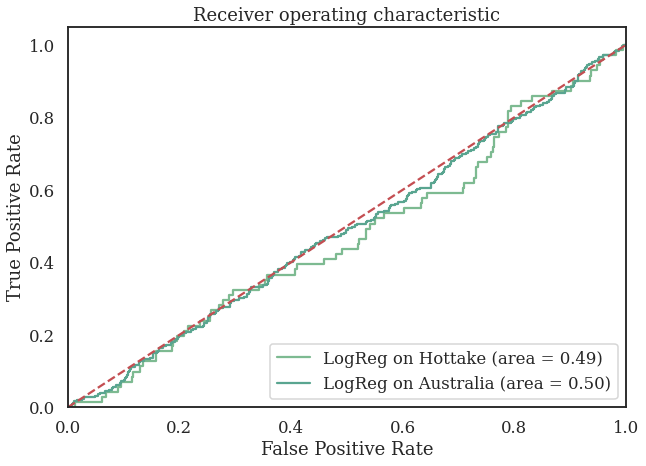

In [33]:
log_roc_auc_hottake = roc_auc_score(y_test_hottake, logreg_hottake.predict(X_test_hottake))
fpr_hottake, tpr_hottake, _ = roc_curve(y_test_hottake, logreg_hottake.predict_proba(X_test_hottake)[:,1])

log_roc_auc_aus = roc_auc_score(y_test_aus, logreg_aus.predict(X_test_aus))
fpr_aus, tpr_aus, _ = roc_curve(y_test_aus, logreg_aus.predict_proba(X_test_aus)[:,1])


plt.figure(figsize = (10,7))
plt.plot(fpr_hottake, tpr_hottake, label='LogReg on Hottake (area = %0.2f)' % log_roc_auc_hottake)
plt.plot(fpr_aus, tpr_aus, label='LogReg on Australia (area = %0.2f)' % log_roc_auc_aus)

plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

# Modeling with Random Forest

In [ ]:
%%time
rmf_hottake = RandomForestClassifier(random_state = 17, class_weight='balanced')
rmf_hottake.fit(X_train_hottake, y_train_hottake)

y_pred_rmf_h = rmf_hottake.predict(X_test_hottake)
y_pred_prob_rmf_h = rmf_hottake.predict_proba(X_test_hottake)
y_pred_prob_log_rmf_h = rmf_hottake.predict_log_proba(X_test_hottake)

print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(rmf_hottake.score(X_test_hottake, y_test_hottake)))

Accuracy of logistic regression classifier on test set: 0.96
CPU times: user 5min 19s, sys: 0 ns, total: 5min 19s
Wall time: 5min 19s


/home/ec2-user/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/sklearn/ensemble/_forest.py:722: RuntimeWarning: divide by zero encountered in log
  return np.log(proba)


In [37]:
print(classification_report(y_test_hottake, y_pred_rmf_h))
print(confusion_matrix(y_test_hottake, y_pred_rmf_h))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98      1831
           1       0.00      0.00      0.00        71

    accuracy                           0.96      1902
   macro avg       0.48      0.50      0.49      1902
weighted avg       0.93      0.96      0.94      1902

[[1831    0]
 [  71    0]]


/home/ec2-user/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ec2-user/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ec2-user/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

In [34]:
%%time
rmf_aus = RandomForestClassifier(random_state = 17, class_weight='balanced')
rmf_aus.fit(X_train_aus, y_train_aus)

y_pred_rmf_a = rmf_aus.predict(X_test_aus)
y_pred_prob_rmf_a = rmf_aus.predict_proba(X_test_aus)
y_pred_prob_log_rmf_a = rmf_aus.predict_log_proba(X_test_aus)

print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(rmf_aus.score(X_test_aus, y_test_aus)))

/home/ec2-user/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/sklearn/ensemble/_forest.py:722: RuntimeWarning: divide by zero encountered in log
  return np.log(proba)


Accuracy of logistic regression classifier on test set: 0.96
CPU times: user 4min 18s, sys: 0 ns, total: 4min 18s
Wall time: 4min 18s


In [35]:
print(classification_report(y_test_aus, y_pred_rmf_a))
print(confusion_matrix(y_test_aus, y_pred_rmf_a))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98      5377
           1       0.00      0.00      0.00       249

    accuracy                           0.96      5626
   macro avg       0.48      0.50      0.49      5626
weighted avg       0.91      0.96      0.93      5626

[[5377    0]
 [ 249    0]]


/home/ec2-user/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ec2-user/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ec2-user/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

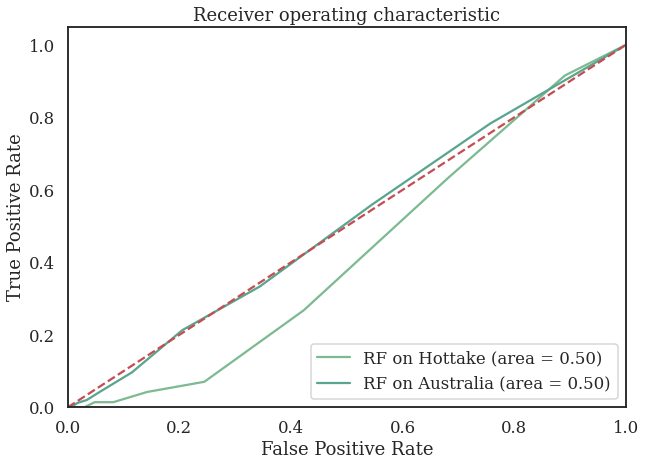

In [39]:
rf_roc_auc_hottake = roc_auc_score(y_test_hottake, rmf_hottake.predict(X_test_hottake))
fpr_hottake, tpr_hottake, _ = roc_curve(y_test_hottake, rmf_hottake.predict_proba(X_test_hottake)[:,1])

rf_roc_auc_aus = roc_auc_score(y_test_aus, rmf_aus.predict(X_test_aus))
fpr_aus, tpr_aus, _ = roc_curve(y_test_aus, rmf_aus.predict_proba(X_test_aus)[:,1])


plt.figure(figsize = (10,7))
plt.plot(fpr_hottake, tpr_hottake, label='RF on Hottake (area = %0.2f)' % rf_roc_auc_hottake)
plt.plot(fpr_aus, tpr_aus, label='RF on Australia (area = %0.2f)' % rf_roc_auc_aus)

plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

## Modeling with AdaBoost

In [ ]:
%%time

# Initialise the model with Decision Tree classifier as the base model
boost = AdaBoostClassifier(base_estimator = DecisionTreeClassifier(), 
                            algorithm = 'SAMME.R', learning_rate=0.1,
                            random_state = 10)

# Fit on the entire data
boost.fit(X_train,y_train)

y_pred_boost = boost.predict(X_test)
y_pred_prob_boost = boost.predict_proba(X_test)
y_pred_prob_log_boost = boost.predict_log_proba(X_test)

print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(boost.score(X_test, y_test)))

In [ ]:
print(confusion_matrix(y_test, y_pred_boost))
print(classification_report(y_test, y_pred_boost))

In [ ]:
adaboost_roc_auc = roc_auc_score(y_test, boost.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, boost.predict_proba(X_test)[:,1])
plt.figure(figsize = (10,7))
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % adaboost_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

# Modeling with HistGradientBoosting

In [ ]:
%%time

# Initialise the model with Decision Tree classifier as the base model
histGB = HistGradientBoostingClassifier(loss='binary_crossentropy', learning_rate=0.1, random_state = 10)

#X_train_smaller = X_train.head(1000)
#y_train_smaller = y_train.head(1000)

# Fit on the entire data
histGB.fit(X_train,y_train)

y_pred_histGB = histGB.predict(X_test)
y_pred_prob_histGB = histGB.predict_proba(X_test)

print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(histGB.score(X_test, y_test)))

In [ ]:
print(confusion_matrix(y_test, y_pred_histGB))
print(classification_report(y_test, y_pred_histGB))

In [ ]:
histgb_roc_auc = roc_auc_score(y_test, histGB.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, histGB.predict_proba(X_test)[:,1])
plt.figure(figsize = (10,7))
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % histgb_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

# Modeling with GradientBoosting

In [ ]:
%%time

# Initialise the model with Decision Tree classifier as the base model
GB = GradientBoostingClassifier(loss='deviance', learning_rate=0.1,random_state = 10)

#X_train_smaller = X_train.head(1000)
#y_train_smaller = y_train.head(1000)

# Fit on the entire data
GB.fit(X_train, y_train)

y_pred_GB = GB.predict(X_test)
y_pred_prob_GB = GB.predict_proba(X_test)
y_pred_prob_log_GB = GB.predict_log_proba(X_test)

print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(GB.score(X_test, y_test)))

In [ ]:
print(confusion_matrix(y_test, y_pred_GB))
print(classification_report(y_test, y_pred_GB))

In [ ]:
gb_roc_auc = roc_auc_score(y_test, GB.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, GB.predict_proba(X_test)[:,1])
plt.figure(figsize = (10,7))
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % gb_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

# Modeling with XGradientBoosting

In [40]:
%pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [41]:
#import xgboost as xgb
from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix

In [42]:
%%time

# fit model no training data
xgb_aus = XGBClassifier()
xgb_aus.fit(X_train_aus, y_train_aus)

print(xgb_aus)

/home/ec2-user/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[03:48:42] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=48,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)
CPU times: user 5h 28min 51s, sys: 5.65 s, total: 5h 28min 56s
Wall time: 7min 2s


In [43]:
%%time

# fit model no training data
xgb_hottake = XGBClassifier()
xgb_hottake.fit(X_train_hottake, y_train_hottake)

print(xgb_hottake)

[03:55:45] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=48,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)
CPU times: user 6h 41min 57s, sys: 5.2 s, total: 6h 42min 2s
Wall time: 8min 34s


In [44]:
y_pred_xgb_hottake = xgb_hottake.predict(X_test_hottake)
y_pred_prob_xgb_hottake = xgb_hottake.predict_proba(X_test_hottake)

y_pred_xgb_aus = xgb_aus.predict(X_test_aus)
y_pred_prob_xgb_aus = xgb_aus.predict_proba(X_test_aus)

In [45]:
print('Accuracy of XGBoost classifier on test set Hottake: {:.2f}'.format(xgb_hottake.score(X_test_hottake, y_test_hottake)))

print('Accuracy of XGBoost classifier on test set Australia: {:.2f}'.format(xgb_aus.score(X_test_aus, y_test_aus)))

Accuracy of XGBoost classifier on test set Hottake: 0.96
Accuracy of XGBoost classifier on test set Australia: 0.96


In [46]:
confusion_matrix(y_test_hottake, y_pred_xgb_hottake)

array([[1831,    0],
       [  71,    0]])

In [47]:
confusion_matrix(y_test_aus, y_pred_xgb_aus)

array([[5377,    0],
       [ 249,    0]])

In [48]:
print(classification_report(y_test_hottake, y_pred_xgb_hottake))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98      1831
           1       0.00      0.00      0.00        71

    accuracy                           0.96      1902
   macro avg       0.48      0.50      0.49      1902
weighted avg       0.93      0.96      0.94      1902



/home/ec2-user/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ec2-user/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ec2-user/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

In [49]:
print(classification_report(y_test_aus, y_pred_xgb_aus))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98      5377
           1       0.00      0.00      0.00       249

    accuracy                           0.96      5626
   macro avg       0.48      0.50      0.49      5626
weighted avg       0.91      0.96      0.93      5626



/home/ec2-user/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ec2-user/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ec2-user/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

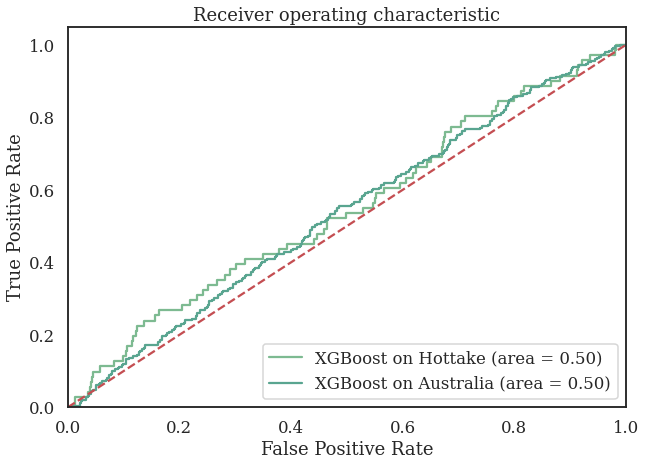

In [50]:
xgb_roc_auc_hottake = roc_auc_score(y_test_hottake, xgb_hottake.predict(X_test_hottake))
fpr_hottake, tpr_hottake, _ = roc_curve(y_test_hottake, xgb_hottake.predict_proba(X_test_hottake)[:,1])

xgb_roc_auc_aus = roc_auc_score(y_test_aus, xgb_aus.predict(X_test_aus))
fpr_aus, tpr_aus, _ = roc_curve(y_test_aus, xgb_aus.predict_proba(X_test_aus)[:,1])


plt.figure(figsize = (10,7))
plt.plot(fpr_hottake, tpr_hottake, label='XGBoost on Hottake (area = %0.2f)' % xgb_roc_auc_hottake)
plt.plot(fpr_aus, tpr_aus, label='XGBoost on Australia (area = %0.2f)' % xgb_roc_auc_aus)

plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

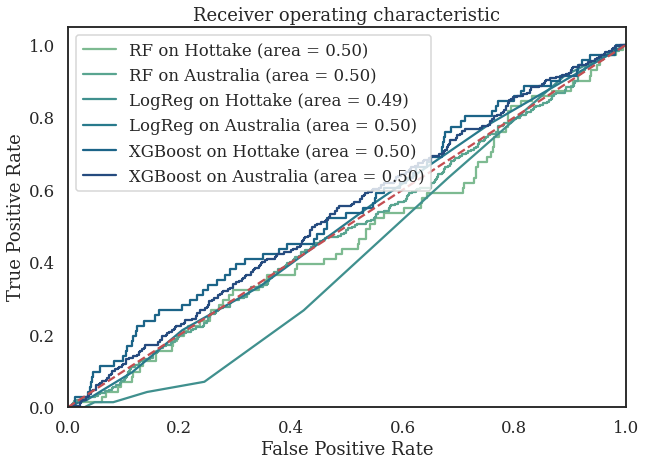

In [52]:
log_roc_auc_hottake = roc_auc_score(y_test_hottake, logreg_hottake.predict(X_test_hottake))
fpr_hottake1, tpr_hottake1, _ = roc_curve(y_test_hottake, logreg_hottake.predict_proba(X_test_hottake)[:,1])

log_roc_auc_aus = roc_auc_score(y_test_aus, logreg_aus.predict(X_test_aus))
fpr_aus1, tpr_aus1, _ = roc_curve(y_test_aus, logreg_aus.predict_proba(X_test_aus)[:,1])

rf_roc_auc_hottake = roc_auc_score(y_test_hottake, rmf_hottake.predict(X_test_hottake))
fpr_hottake2, tpr_hottake2, _ = roc_curve(y_test_hottake, rmf_hottake.predict_proba(X_test_hottake)[:,1])

rf_roc_auc_aus = roc_auc_score(y_test_aus, rmf_aus.predict(X_test_aus))
fpr_aus2, tpr_aus2, _ = roc_curve(y_test_aus, rmf_aus.predict_proba(X_test_aus)[:,1])


xgb_roc_auc_hottake = roc_auc_score(y_test_hottake, xgb_hottake.predict(X_test_hottake))
fpr_hottake3, tpr_hottake3, _ = roc_curve(y_test_hottake, xgb_hottake.predict_proba(X_test_hottake)[:,1])

xgb_roc_auc_aus = roc_auc_score(y_test_aus, xgb_aus.predict(X_test_aus))
fpr_aus3, tpr_aus3, _ = roc_curve(y_test_aus, xgb_aus.predict_proba(X_test_aus)[:,1])


plt.figure(figsize = (10,7))

plt.plot(fpr_hottake1, tpr_hottake1, label='RF on Hottake (area = %0.2f)' % rf_roc_auc_hottake)
plt.plot(fpr_aus1, tpr_aus1, label='RF on Australia (area = %0.2f)' % rf_roc_auc_aus)

plt.plot(fpr_hottake2, tpr_hottake2, label='LogReg on Hottake (area = %0.2f)' % log_roc_auc_hottake)
plt.plot(fpr_aus2, tpr_aus2, label='LogReg on Australia (area = %0.2f)' % log_roc_auc_aus)


plt.plot(fpr_hottake3, tpr_hottake3, label='XGBoost on Hottake (area = %0.2f)' % xgb_roc_auc_hottake)
plt.plot(fpr_aus3, tpr_aus3, label='XGBoost on Australia (area = %0.2f)' % xgb_roc_auc_aus)

plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="best")
plt.savefig('Log_ROC')
plt.show()
